In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [2]:
df = pd.read_csv('Data\WMT.csv')
df

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828
...,...,...
5474,2020-12-25,NaN
5475,2020-12-28,142.946777
5476,2020-12-29,142.041183
5477,2020-12-30,141.923065


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
df = df[(df['Date'].dt.year>=2010) & (df['Date'].dt.year <=2020)]

In [5]:
df = df.set_index('Date')
df = df.asfreq('B')

In [6]:
df.isnull().sum()

Adj Close    101
dtype: int64

In [7]:
df = df.ffill()

Had one null left so I dropped it.

In [8]:
df.isnull().sum()

Adj Close    1
dtype: int64

In [9]:
df.dropna(subset=['Adj Close'], inplace=True)

In [10]:
df

,Adj Close
Date,
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
2010-01-08,40.283802
...,...
2020-12-25,141.253738
2020-12-28,142.946777
2020-12-29,142.041183


<Axes: xlabel='Date'>

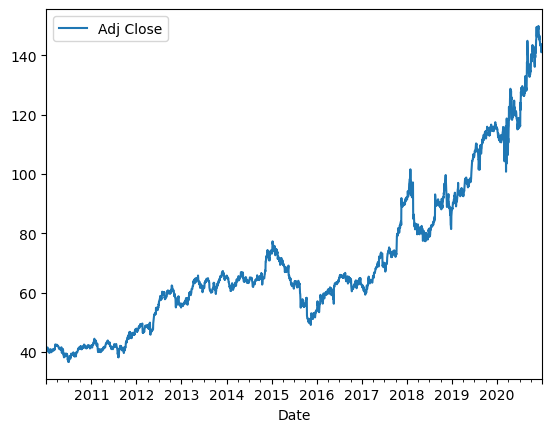

In [11]:
df.plot()

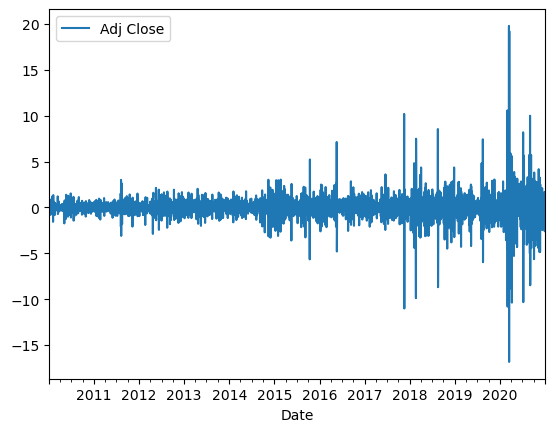

In [12]:
df.diff().diff().plot();

In [13]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [14]:
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


In [15]:
get_adfuller_results(df.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


In [16]:
get_adfuller_results(df.diff().diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-18.757916,28,2838,0.0,0.05,True


Need to difference once

In [17]:
ndiffs(df)

1

In [21]:
df_diff1= df.diff().diff().dropna()

In [19]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig


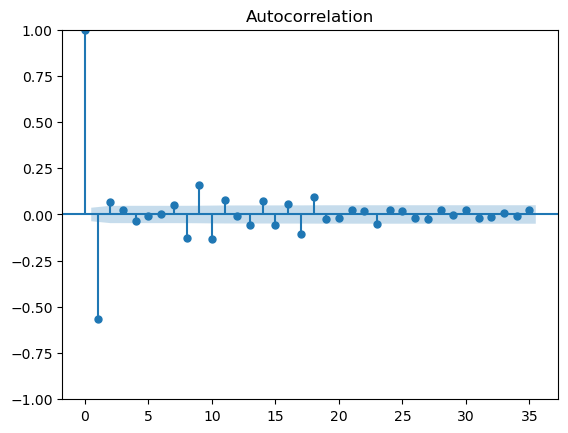

In [23]:
tsa.graphics.plot_acf(df_diff1);

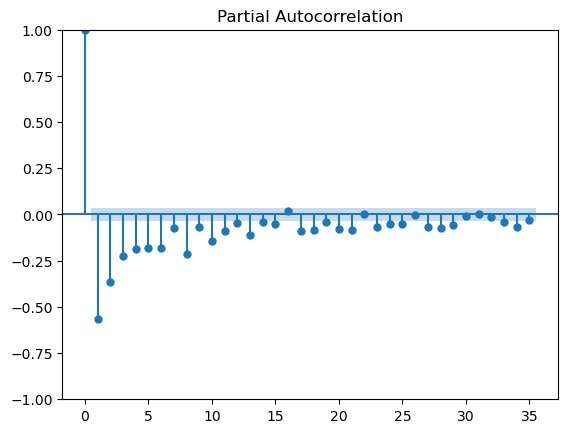

In [24]:
tsa.graphics.plot_pacf(df_diff1['Adj Close']);

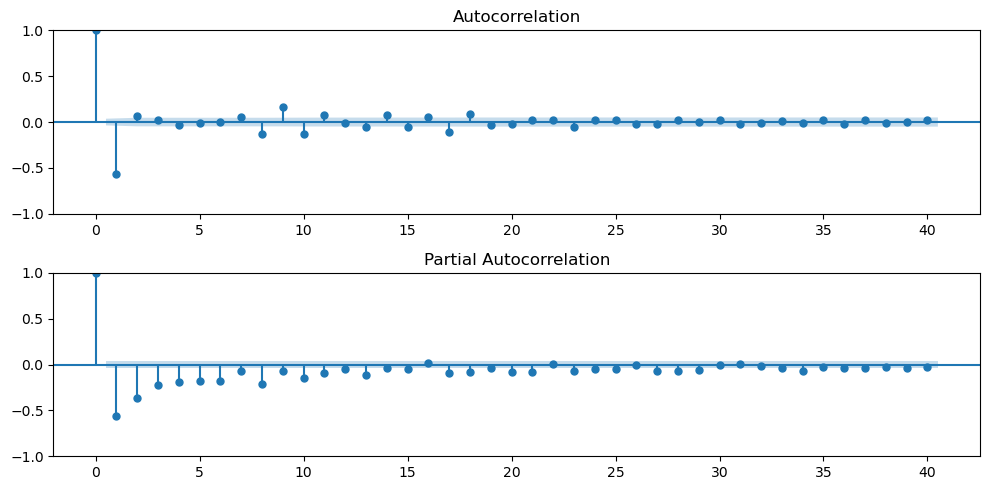

In [26]:
plot_acf_pacf(df_diff1);

In [27]:
train, test = train_test_split(df, test_size = 65)
